# Predicting Color Classes from 2D Coordinates Using a Neural Network

## Project Steps

- **Data Preparation**: Create arrays of 2D coordinates (`x`, `y`) and corresponding color labels, and split data into training and test sets.
- **Model Creation**: Use PyTorch to create a neural network for multi-class classification.
- **Training**: Train the model for multiple epochs.
- **Evaluation**: Evaluate the model using the test data and predict color classes.
- **Visualization**: Generate a grid of points, predict color classes, and create a scatter plot to visualize the results.

This project demonstrates 2D spatial classification using a neural network in PyTorch.

In [2]:
import torch
from matplotlib import pyplot
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
torch.__version__

'2.0.1+cu117'

## Data Generation

In [15]:
color_map = ["red", "blue", "green"]

num_points = 3000
square_size = 800
x = torch.rand(num_points) * square_size
y = torch.rand(num_points) * square_size
color_indices = torch.randint(0, len(color_map), (num_points,))
x -= square_size / 2
y -= square_size / 2
colors = []

def prob_fn(val, zero_val):
    return val * (-1 / zero_val) + 1

for i in range(num_points):
    x0 = x[i]
    y0 = y[i]
    rand = torch.rand(1).item()

    origin_dist = torch.hypot(x0, y0)
    circle_start = 300
    if origin_dist > circle_start and rand > prob_fn(origin_dist - circle_start, 100) and not (x0 > 0 and y0 < 0):
        colors.append(2)
        continue

    eval_f = x0 * x0 / 100
    dist = abs(eval_f - y0)

    if rand > prob_fn(dist, 130):
        colors.append(0)
    else:
        colors.append(1)

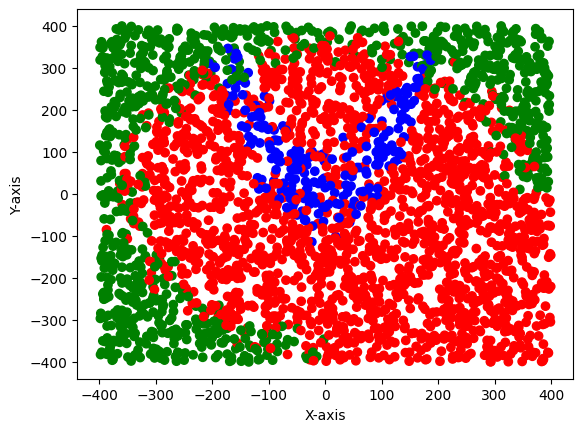

In [17]:
pyplot.scatter(x, y, c=[color_map[i] for i in colors])
pyplot.xlabel("X-axis")
pyplot.ylabel("Y-axis")
pyplot.show()

In [18]:
X = torch.stack((x, y), dim=1)
X

tensor([[ 368.5453,   84.7523],
        [ -48.5014,  271.6370],
        [ 239.3939,  -67.4751],
        ...,
        [ 289.5610, -265.4366],
        [ -79.0287,  295.8665],
        [ 348.4258, -263.2985]])

In [19]:
y_labels = torch.tensor(colors)

y_labels, Counter(y_labels.tolist())

(tensor([2, 0, 0,  ..., 0, 0, 0]), Counter({0: 1845, 2: 929, 1: 226}))

## Model Creation

In [20]:
class ColorPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ColorPredictionModel, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x

## Training

In [21]:
def split_data(X, y_labels):
    indices = torch.randperm(X.size(0))
    train_size = int(0.8 * X.size(0))
    test_size = X.size(0) - train_size

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    return X[train_indices], X[test_indices], y_labels[train_indices], y_labels[test_indices]

X_train, X_test, y_train, y_test = split_data(X, y_labels)

In [22]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

model = ColorPredictionModel(input_size=2, hidden_size=64, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [10/100], Loss: 0.3852
Epoch [20/100], Loss: 0.3061
Epoch [30/100], Loss: 0.2900
Epoch [40/100], Loss: 0.2816
Epoch [50/100], Loss: 0.2810
Epoch [60/100], Loss: 0.2587
Epoch [70/100], Loss: 0.2649
Epoch [80/100], Loss: 0.2493
Epoch [90/100], Loss: 0.2523
Epoch [100/100], Loss: 0.2539


## Model Testing and Visualization

In [23]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

Accuracy on test data: 88.50%


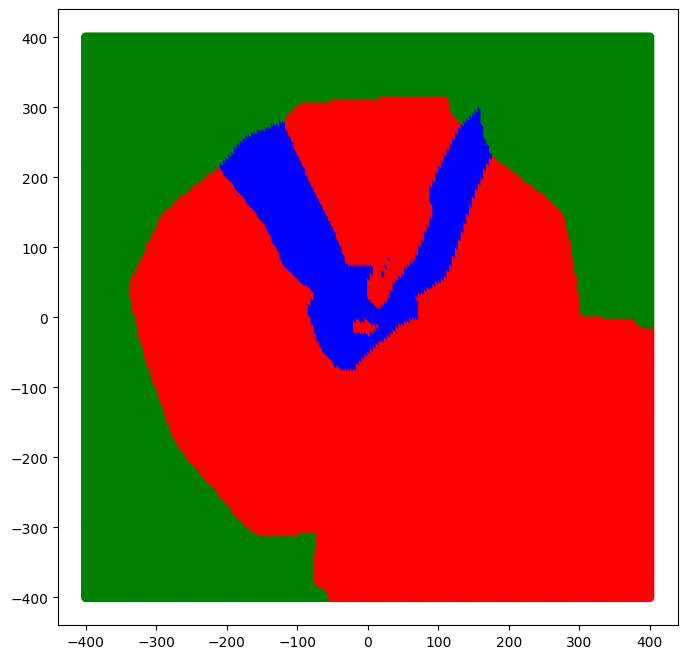

In [24]:
x_range = torch.linspace(-400, 400, 200)
y_range = torch.linspace(-400, 400, 200)

x_grid, y_grid = torch.meshgrid(x_range, y_range, indexing="ij")

grid_points = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

model.eval()

with torch.no_grad():
    outputs = model(grid_points)
    predicted_classes = torch.argmax(outputs, dim=1)

pyplot.figure(figsize=(8, 8))
pyplot.scatter(x_grid, y_grid, c=[color_map[i] for i in predicted_classes])
pyplot.show()